In [10]:
from typing import Tuple
from collections import defaultdict
import numpy as np
import pandas as pd


class Trace:

    def __init__(self, filename: str, benchmarks=None, ignore=None, parse_progress=True):
        self.baseline = set(benchmarks) if benchmarks else set()
        self.scores, self.expressions, generations_by_task, self.baseline, self.progdf = parse_log(filename, baseline=self.baseline,ignore=ignore,parse_progress=parse_progress)
        self.comparison, self.d_scores = comparisons(self.scores)
        self.in_comparison, self.in_d_scores = comparisons(self.scores, sample="in-sample")
        self.generations_by_task = pd.Series(generations_by_task, name="generations")

    @property
    def most_frequent_solutions_by_length(self):
        for length, expressions in sorted(self.expressions.items()):
            m = max(set(expressions), key=expressions.count)
            yield m, expressions.count(m)
            # print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")


def parse_log(file, with_prefix=False, baseline=None, ignore=None, parse_progress=True):
    with open(file) as fh:
        lines = fh.readlines()
        
    # ignore lines with an expression that is asked to be ignored
    lines = [line for line in lines if not any([i in line for i in ignore])]

    p = 'INFO:root:' if with_prefix else ''

    definitions = [line for line in lines if ':=' in line]
    baseline = baseline if baseline else set()
    
    print("The predefined defaults are (may show a repeat):")
    for line in definitions:
        if ':=' in line and [i in line for i in ignore]:
            print(f" * {line[len(p):-1]}")
            baseline.add(line[len(p):].split(' :=')[0])

    task_starts = [i for i, line in enumerate(lines) if "START_TASK:" in line]
    in_sample_starts = [i for i, line in enumerate(lines) if "Evaluating in sample:" in line]
    out_sample_starts = [i for i, line in enumerate(lines) if "Evaluating out-of-sample:" in line]

    def parse_evaluation_line(line) -> Tuple[str, int, float]:
        """ Parse an evaluation line, returning the expression or name, its 'length' and the score.

        e.g. INFO:root:[make_tuple(p, mkd)|0.8893]\n -> 'make_tuple(p, mkd)', 1, 0.8893
        Length is 0 for benchmark problems.
        """
        if line.count('|') == 1:
            start, pipe, end = line.find('['), line.find('|'), line.find(']')
        else:
            start, end = line.find('|') + 1, line.find(']')
            pipe = line.find('|', start)            
            
        expression = line[start + 1: pipe]
        if ':' in expression:  # For the baseline expressions, record them by name
            expression = expression[:expression.find(':')]
        expression_length = expression.count('(')
        return expression, expression_length, float(line[pipe + 1: end])
    
    def parse_progess_lines(task, lines) -> pd.DataFrame:
        """
        Parse the log files progress over generations 
        Lines that evaluate progress start with 'GEN_' followed by Fitness and Size values
        """
        progdf = pd.DataFrame(columns = ['task','gen', 'min', 'avg', 'max'])
        for i, line in enumerate(lines):
            progdf.loc[len(progdf)] =  [task, i] + [float(x) for x in line[line.find("FIT_")+4:line.find("_SIZE")].split("_")]
        return progdf


    tasks = [int(line[:-1].split(": ")[-1]) for line in lines if "START_TASK:" in line]
    idx = pd.MultiIndex.from_product([tasks, ["in-sample", "out-sample"]], names=['task', 'sample-type'])
    df = pd.DataFrame(index=idx, columns=["length-1", "length-2", "length-3", "final", *baseline], dtype=float)

    expressions_by_length = defaultdict(list)
    generations_by_task = {}
    progdf = pd.DataFrame(columns = ['task','gen', 'min', 'avg', 'max'])

    for task_start, next_task in zip(task_starts, task_starts[1:] + [-(len(baseline)*2 + 1)]):
        # start line looks like: INFO:root:START_TASK: 29\n
        task = int(lines[task_start][:-1].split(": ")[-1])
        generations_by_task[task] = 0
        gen_lines = []
        
        # Following the "INFO:root:Evaluating in sample:" message, symbolic default performance are printed
        # They are formatted as "INFO:root:[make_tuple(p, mkd)|0.8893]"
        # First is any number of best solutions from the pareto front. The last four are benchmark solutions.
        # It is possible that two equally good solutions are printed (i.e. same length and performance).
        expr_in_task = set()
        max_length = 0
        last_insample = []
        last_outsample = []
        
        in_sample = True
        for line in lines[task_start:next_task]:
            if line.startswith('GEN_'):
                generations_by_task[task] += 1
                gen_lines.append(line)
            if "Evaluating in sample:" in line:
                in_sample = True
                last_insample = []
                last_outsample = []
                expr_in_task = set()            
                expressions_by_length = defaultdict(list)
            if "Evaluating out-of-sample:" in line:
                in_sample = False
            if line.startswith('['):                
                expr, length, score = parse_evaluation_line(line)
                if expr not in expr_in_task: # and ':' not in expr:
                    expressions_by_length[length].append(expr)
                    expr_in_task.add(expr)
                if in_sample:
                    last_insample.append((expr, length, score))
                else:
                    last_outsample.append((expr, length, score))            
        
        # Parse optimization trace (all lines starting with 'GEN_')
        if parse_progress:
            progdf = progdf.append(parse_progess_lines(task, gen_lines), ignore_index=True)

        for expr, length, score in last_insample:
            if length != 0:
                if length < 4:
                    # Only report one out-of-sample solution for each length (and all benchmarks), so overwrite is OK.
                    df.loc[task, "in-sample"][f"length-{length}"] = score

                # Update best so far score and maximum length
                df.loc[task, "in-sample"][f"final"] = np.nanmax(
                    [score, df.loc[task, "in-sample"][f"final"]])
                max_length = max(max_length, length)
            else:
                df.loc[task, "in-sample"][expr] = score

            if length > max_length:
                max_length = length  # To know for which length "best" should score out of sample

        # Because two equal solutions can be in the Pareto front,
        # we note the average out of sample performance if multiple solutions were found.
        # Naturally, the solutions with the best in-sample score were those with the highest length in the Pareto front.

        scores_by_length = defaultdict(list)
        for expr, length, score in last_outsample:
            if length != 0:
                scores_by_length[length].append(score)
            else:
                df.loc[task, "out-sample"][expr] = score

        for length, scores in scores_by_length.items():
            if length < 4:
                df.loc[task, "out-sample"][f"length-{length}"] = np.mean(scores)
            if length == max_length:
                df.loc[task, "out-sample"][f"final"] = np.mean(scores)
            if np.mean(scores) == float("nan"):
                print('hi')

    return df, expressions_by_length, generations_by_task, baseline, progdf


def comparisons(df, sample="out-sample"):
    out_sample = df.index.map(lambda idx: idx[1] == sample)

    alone = {k: 0 for k in df.iloc[0].index.values}
    shared = {k: 0 for k in df.iloc[0].index.values}

    for _, out in df.loc[out_sample].iterrows():
        best = out[out == out.max()].index.values
        if len(best) == 1:
            alone[best[0]] += 1
        else:
            for winner in best:
                shared[winner] += 1

    alone = {k: alone[k] for k in sorted(alone)}
    shared = {k: shared[k] for k in sorted(shared)}
    either = {k: shared[k] + alone[k] for k in sorted({**alone, **shared})}
    comparison = pd.DataFrame([alone, shared, either], index=['alone', 'shared', 'either'])

    df_out = df.loc[out_sample].copy()
    df_out['max'] = df_out.max(axis=1)
    for col in df_out:
        df_out['d_' + col] = df_out['max'] - df_out[col]
    d_cols = [c for c in df_out.columns if c.startswith('d_')]
    df_out[d_cols].mean()
    df_out[d_cols].median()

    in_sample = df.index.map(lambda idx: idx[1] == "in-sample")
    df.loc[in_sample].idxmax(axis=1).value_counts()
    df.loc[in_sample][reversed(df.columns)].idxmax(axis=1).value_counts()
    return comparison, df_out


In [2]:
from collections import defaultdict
from typing import Tuple
import numpy as np
import pandas as pd

# Symbolic Defaults by 'complexity' of expression
In this notebook we take a look at the results of running the script at its default settings, this means:
 - evaluation across all tasks
 - recording the pareto front of symbolic defaults after each search
 - evaluating in-sample and out-of-sample performance of those dynamic defaults, as well as some pre-defined ones
 
**note:** The console cut off results for the first few tasks, so I am rerunning those now.

For each task we will extract:
 - the number of generations optimization ran for (max=200)
 - max length expression
 - in and out of sample performance for length 1, 2 and 3 expression

For each task save the benchmark results. We also save results for length 1, 2 and 3 solutions as well as the best one found (that may be longer). Specifically we record:
 - best in_sample performance at length 1, 2, 3
 - best in_sample performance for any length
 - average out_sample performance by length for length 1, 2, 3
 - average out_sample performance for the longest (i.e. best in-sample score) solution(s).

## Setup
We have experiment data for a set of algorithms and meta-data for the datasets on which the experiments took place.
We use symbolic regression to find an expression for symbolic default values that give good performance across tasks.
Symbolic regression is performed with leave-one-task-out, which means for each algorithm we have multiple searches for a symbolic default, and their performance is recorded for both in-sample (the optimization surface of all-but-one tasks) and out-of-sample (the left out task) performance. Performance here is solely based on surrogate model predictions, no additional experiments have been performed (yet).

In our search, we use NSGA-II selection to perform multi-objective optimization: find the expression with the best performance, while using the fewest number of operators (e.g. `divide`, `multiply`).

### Terms
**Length** of an expression denotes the number of operators in it. A symbolic value is *not* considered an operation.
Consider the following SVM defaults for cost and gamma:
 - `make_tuple`(m, mkd) is length 1.
 - `make_tuple`(m, `truediv`(mkd, xvar)) is length 2.
 - `make_tuple`(16., `truediv`(mkd, xvar)) is length 2.

The **final** solution refers to the symbolic default with the highest in-sample score for a task (regardless of its length). This means for each task there is *at least* one final solution, but there may be more and they are not of a specific length.


The **baseline** solutions are typically the default hyperparameter settings of mlr, scikit-learn, or both.

---

We read all the logs, because some logs are incomplete we have to explicitly give the name of the baselines (this will be fixed for future runs).

In [14]:
alg = 'mlr_svm_lisa'
run_one = f"{alg}_gauss24"
run_two = f"{alg}_cst"

import os
baselines = dict(
    glmnet=["mlr_default", "sklearn_default"],
    kerasff=["initial_values"],
    knn=["mlr_default"],
    rf=["mlr_default"],
    rpart=["mlr_default"],
    asvm=["sklearn_scale", "symbolic_best", "symbolic_v2" , "const"],
)
traces = {}
for file in os.listdir('runs'):
    if file.endswith('.log') and alg in file:
        print(file)
        baseline = []
        for method, bls in baselines.items():
            if method in file:
                baseline = bls
        traces[file[:-4]] = Trace(os.path.join('runs', file), benchmarks=baseline, ignore=["const", "symbolic_v2"])

mlr_svm_lisa.log
The predefined defaults are (may show a repeat):
 * sklearn_default := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
 * sklearn_default := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
mlr_svm_lisa_gauss24.log
The predefined defaults are (may show a repeat):
 * sklearn_default := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
 * sklearn_default := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
mlr_svm_lisa_gauss24_1eph.log
The predefined defaults are (may show a repeat):
 * sklearn_default := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
 * sklearn_default := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
mlr_svm_lisa_gauss24_1eph_d1.log
The predefined defaults are 

O:\Anaconda\envs\symbdef\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


mlr_svm_lisa_gauss24_1eph_d1_3.log
The predefined defaults are (may show a repeat):
 * sklearn_default := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
 * sklearn_default := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
mlr_svm_lisa_gauss24_1eph_d1_3i.log
The predefined defaults are (may show a repeat):
 * sklearn_default := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
 * sklearn_default := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
 * sklearn_default := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
 * sklearn_default := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
 * sklearn_default := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd

### Optimization
As described before, for each problem we find a symbolic default leaving one task out.
We are interested to see how fast the symbolic regression converges across tasks.

In [15]:
print("Median number of generations across tasks by problem:")
for log, trace in traces.items():
    print(f"{log: <15} {trace.generations_by_task.median().astype(int):3d}")

Median number of generations across tasks by problem:
mlr_svm_lisa     60
mlr_svm_lisa_gauss24  87
mlr_svm_lisa_gauss24_1eph  70
mlr_svm_lisa_gauss24_1eph_d1  67
mlr_svm_lisa_gauss24_1eph_d1_2  66
mlr_svm_lisa_gauss24_1eph_d1_2i  40
mlr_svm_lisa_gauss24_1eph_d1_3  66
mlr_svm_lisa_gauss24_1eph_d1_3i  42
mlr_svm_lisa_gauss24_1eph_d1_4  64
mlr_svm_lisa_gauss24_1eph_d1_4i  37


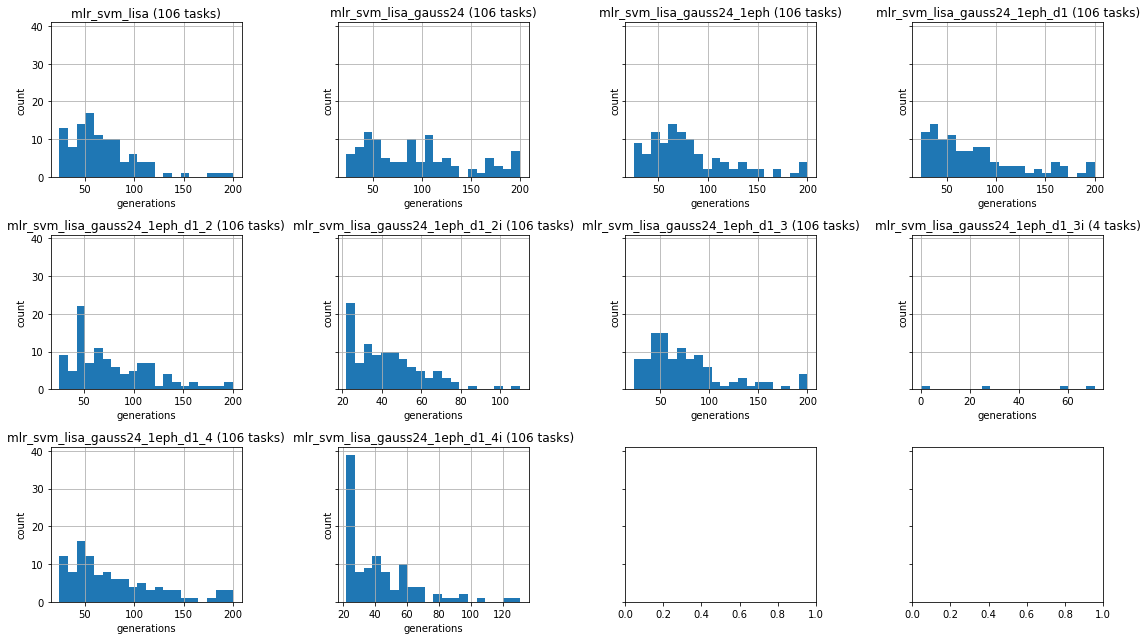

In [16]:
import matplotlib.pyplot as plt
import math

fig, axes = plt.subplots(math.ceil(len(traces) / 4), 4, sharey=True, figsize=(16, 9))
for ax, (log, trace) in zip(axes.flatten(), traces.items()):
    traces[log].generations_by_task.hist(bins=20, ax=ax)
    ax.set_title(f"{log} ({len(trace.generations_by_task)} tasks)")
    ax.set_ylabel('count')
    ax.set_xlabel('generations')
fig.tight_layout()

The plot above shows a histogram counting the number of generations until stopping. These results were obtained with default setting of early stopping if no improvement was made after 20 generations, with a 200 generation maximum.

### Visualizing optimization traces
The traces contain the full optimization traces inside the trace's **progdf** trace.


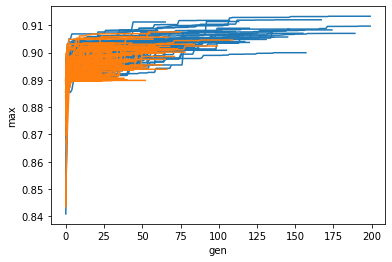

In [19]:
import seaborn as sns
sns.lineplot(x='gen', y='max', units='task', estimator=None, data=traces[f'{alg}_gauss24_1eph_d1_2'].progdf)
sns.lineplot(x='gen', y='max', units='task', estimator=None, data=traces[f'{alg}_gauss24_1eph_d1_2i'].progdf)

### Comparing Expressions
For a given problem, we have a Pareto front of solutions for search (=each left out task).
This Pareto front may contain "twins", multiple solutions which performance equally well and have the same length.
Given that the response surface does not differ *that* much when leaving any particular task out, we hope that the symbolic expressions we find are reasonably consistent across searches.
To have some indication of how consistent the results are, for each problem we find the most frequent solutions of length 1, 2 and 3. We also note the number of hyperparameters for which we aim to find a symbolic default, as we expect this to be correlated to how consistent the solutions are:

In [23]:
expr_count = pd.DataFrame(np.zeros((5, len(traces))), columns=list(traces), index=[1, 2, 3, "#tasks", "params"])
for log, trace in traces.items():  
    for length, expressions in sorted(trace.expressions.items()):
        if 0 < length < 4:
            m = max(set(expressions), key=expressions.count)
            expr_count.loc[length][log] = expressions.count(m)
            # print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")
            if length == 1:
                expr_count.loc["#tasks"][log] = len(trace.scores) / 2
                expr_count.loc["params"][log] = m.count(',') + 1
expr_count

,mlr_svm_lisa,mlr_svm_lisa_gauss24,mlr_svm_lisa_gauss24_1eph,mlr_svm_lisa_gauss24_1eph_d1,mlr_svm_lisa_gauss24_1eph_d1_2,mlr_svm_lisa_gauss24_1eph_d1_2i,mlr_svm_lisa_gauss24_1eph_d1_3,mlr_svm_lisa_gauss24_1eph_d1_3i,mlr_svm_lisa_gauss24_1eph_d1_4,mlr_svm_lisa_gauss24_1eph_d1_4i
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
#tasks,106.0,106.0,106.0,106.0,106.0,106.0,106.0,4.0,106.0,106.0
params,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


We can look at the found expressions per problem:

In [24]:
a = f'{alg}_gauss24_1eph_d1_2i' # run_one #f"mlr_knn_lisa_gaussian" # run_one
for log, trace in traces.items():
    print(log)
    for length, expressions in sorted(trace.expressions.items()):
        if 0 < length < 4:
            m = max(set(expressions), key=expressions.count)
            expr_count.loc[length][log] = expressions.count(m)
            # print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")
            print(f"Most frequent length {length} solution in Pareto front ({expressions.count(m)} times in {len(traces[a].scores) // 2} tasks):\n     {m}")

mlr_svm_lisa
Most frequent length 1 solution in Pareto front (1 times in 106 tasks):
     make_tuple(p, mkd)
Most frequent length 2 solution in Pareto front (1 times in 106 tasks):
     make_tuple(m, truediv(mkd, xvar))
Most frequent length 3 solution in Pareto front (1 times in 106 tasks):
     make_tuple(add(m, 0.25), truediv(mkd, xvar))
mlr_svm_lisa_gauss24
Most frequent length 1 solution in Pareto front (1 times in 106 tasks):
     make_tuple(p, mkd)
Most frequent length 2 solution in Pareto front (1 times in 106 tasks):
     make_tuple(if_gt(mcp, 0.7879207310661787, m, p), mkd)
Most frequent length 3 solution in Pareto front (1 times in 106 tasks):
     make_tuple(if_gt(mcp, 0.7879207310661787, mul(mcp, m), p), mkd)
mlr_svm_lisa_gauss24_1eph
Most frequent length 1 solution in Pareto front (1 times in 106 tasks):
     make_tuple(p, mkd)
Most frequent length 2 solution in Pareto front (1 times in 106 tasks):
     make_tuple(m, truediv(mkd, xvar))
Most frequent length 3 solution in P

## Expression Quality
The expressions we find also need to be good.
Here we compare the following 'strategies':
 - length-*n*: always pick the best expression of length *n*
 - *final*: always pick the best expression, regardless of length
 - *baseline(s)*: compare it to baselines we defined
 
We want to know (all based on out-of-sample performance):
 - which strategy gives the best solution most often?
 - which strategy experiences the least mean regret?
 - which strategy experiences the least median regret?
 
As mentioned before, there can be "twins" in the Pareto front, which means multiple solutions with equal length have equal in-sample performance.
In this case we average the out-of-sample score of those twins.

#### number of wins:

The following table records the number of times a strategy led to the symbolic expression with the best out-of-sample performance (multiple strategies can be the best each task):

In [20]:
out_comparisons = pd.DataFrame()
for log, trace in traces.items():
    out_comparisons = out_comparisons.append(trace.comparison.loc['either'].rename(log))
out_comparisons

,final,length-1,length-2,length-3,sklearn_default,symbolic_best
mlr_svm_lisa,27.0,37.0,24.0,11.0,23.0,29.0
mlr_svm_lisa_gauss24,26.0,36.0,30.0,14.0,24.0,28.0
mlr_svm_lisa_gauss24_1eph,18.0,39.0,19.0,14.0,22.0,31.0
mlr_svm_lisa_gauss24_1eph_d1,23.0,37.0,20.0,14.0,25.0,35.0
mlr_svm_lisa_gauss24_1eph_d1_2,21.0,37.0,25.0,15.0,26.0,32.0
mlr_svm_lisa_gauss24_1eph_d1_2i,54.0,57.0,38.0,5.0,0.0,25.0
mlr_svm_lisa_gauss24_1eph_d1_3,21.0,38.0,25.0,12.0,26.0,29.0
mlr_svm_lisa_gauss24_1eph_d1_3i,1.0,2.0,1.0,0.0,0.0,0.0
mlr_svm_lisa_gauss24_1eph_d1_4,22.0,34.0,25.0,13.0,25.0,29.0
mlr_svm_lisa_gauss24_1eph_d1_4i,55.0,59.0,32.0,4.0,0.0,25.0


#### median regret:
The following table records the median regret for a specific strategy compared to picking the best in hindsight:

In [21]:
medians = pd.DataFrame()
for log, trace in traces.items():
    m = trace.d_scores.median().rename(log)
    medians = medians.append(m)
medians[[c for c in medians.columns if 'd_' in c and c != 'd_max']]

O:\Anaconda\envs\symbdef\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


,d_final,d_length-1,d_length-2,d_length-3,d_sklearn_default,d_symbolic_best
mlr_svm_lisa,0.00285,0.00775,0.00565,0.00280,0.0116,0.00340
mlr_svm_lisa_gauss24,0.00465,0.00755,0.00310,0.00460,0.0122,0.00335
mlr_svm_lisa_gauss24_1eph,0.00640,0.00450,0.01065,0.00575,0.0110,0.00275
mlr_svm_lisa_gauss24_1eph_d1,0.00610,0.00670,0.00985,0.01070,0.0110,0.00295
mlr_svm_lisa_gauss24_1eph_d1_2,0.00745,0.00710,0.00455,0.00650,0.0110,0.00295
mlr_svm_lisa_gauss24_1eph_d1_2i,0.00000,0.00000,0.00460,0.01285,0.0802,0.07255
mlr_svm_lisa_gauss24_1eph_d1_3,0.00635,0.00710,0.00495,0.00770,0.0107,0.00505
mlr_svm_lisa_gauss24_1eph_d1_3i,0.00460,0.00000,0.00460,NaN,0.0771,0.06980
mlr_svm_lisa_gauss24_1eph_d1_4,0.00650,0.00605,0.00750,0.00980,0.0110,0.00360
mlr_svm_lisa_gauss24_1eph_d1_4i,0.00000,0.00000,0.00140,0.01070,0.0772,0.06980


#### mean regret:
The following table records the mean regret for a specific strategy compared to picking the best in hindsight:

In [ ]:
means = pd.DataFrame([])
for log, trace in traces.items():
    m = trace.d_scores.mean().rename(log)
    means = means.append(m)
means[[c for c in medians.columns if 'd_' in c and c != 'd_max']]

### Sanity Checks
Sometimes out-of-sample performance of a baseline may still be better than that of our solution.
However, in-sample performance of our own solutions should always be better than any baseline.
If that is not the case, this would indicate our search does not explore the space well enough.

In [25]:
in_sample_comparisons = pd.DataFrame()
for log, trace in traces.items():
    in_sample_comparisons = in_sample_comparisons.append(trace.in_comparison.loc['either'].rename(log))
in_sample_comparisons

,final,length-1,length-2,length-3,sklearn_default,symbolic_best
mlr_svm_lisa,91.0,0.0,45.0,20.0,0.0,15.0
mlr_svm_lisa_gauss24,104.0,0.0,39.0,21.0,0.0,4.0
mlr_svm_lisa_gauss24_1eph,104.0,0.0,33.0,24.0,0.0,2.0
mlr_svm_lisa_gauss24_1eph_d1,101.0,0.0,33.0,22.0,0.0,6.0
mlr_svm_lisa_gauss24_1eph_d1_2,104.0,0.0,37.0,38.0,0.0,5.0
mlr_svm_lisa_gauss24_1eph_d1_2i,106.0,16.0,77.0,11.0,0.0,0.0
mlr_svm_lisa_gauss24_1eph_d1_3,102.0,0.0,33.0,30.0,0.0,4.0
mlr_svm_lisa_gauss24_1eph_d1_3i,3.0,0.0,3.0,0.0,0.0,0.0
mlr_svm_lisa_gauss24_1eph_d1_4,103.0,0.0,39.0,27.0,0.0,5.0
mlr_svm_lisa_gauss24_1eph_d1_4i,106.0,27.0,66.0,7.0,0.0,0.0


### Comparison to random search 
The following provides an overview over scores for different iterations of random search

In [ ]:
name = "mlr_svm"
rsdf = pd.read_csv("data/"+name+"_baselines.csv", index_col=0)
rsdf.iloc[:,1:].apply(np.mean,axis=1)

----
End of notebook - just sketchpad below

In [ ]:
alg

In [ ]:
trace.scores.isna().any(axis=0)

In [ ]:
alg = "svm"
run_one = "mlr_svm_lisa"
minimum = dict(knn=100, svm=100, glmnet=100, rpart=60)
final_scores = pd.DataFrame()
for log, trace in traces.items():
    # Filter out runs with >100 tasks completed:
    if len(trace.scores) / 2 > minimum[alg]:
        out_sample = trace.scores.index.map(lambda idx: idx[1] == "out-sample")
        log_oos = trace.scores.loc[out_sample].final.rename(log)
        final_scores = final_scores.append(log_oos)
        if log == run_one:
            # contains benchmark scores
            for b in trace.baseline:
                baseline_score = trace.scores.loc[out_sample][b].rename(b)
                final_scores = final_scores.append(baseline_score)
final_scores

In [ ]:
# filter out incomplete tasks:
final = final_scores.loc[:, ~final_scores.isna().any()]
df = final

In [ ]:
run_one="mlr_svm_lisa"
run_two="svm_warm"

In [ ]:
df = df.loc[[run_one, run_two]]

In [ ]:
alone = {k: 0 for k in df.index.values}
shared = {k: 0 for k in df.index.values}

for _, out in df.T.iterrows():
    best = out[out == out.max()].index.values
    if len(best) == 1:
        alone[best[0]] += 1
    else:
        for winner in best:
            shared[winner] += 1

alone = {k: alone[k] for k in sorted(alone)}
shared = {k: shared[k] for k in sorted(shared)}
either = {k: shared[k] + alone[k] for k in sorted({**alone, **shared})}
comparison = pd.DataFrame([alone, shared, either], index=['alone', 'shared', 'either'])
comparison


In [ ]:
df_out = df.T.copy()
df_out['max'] = df_out.max(axis=1)
for col in df_out:
    df_out['d_' + col] = df_out['max'] - df_out[col]
d_cols = [c for c in df_out.columns if c.startswith('d_') and 'max' not in c]
df_out[d_cols].mean()

In [ ]:
df_out[d_cols].median()

In [ ]:
ax = (df.loc[run_one] - df.loc[run_two]).hist(bins=[(f / 40 - 1) for f in range(81)])
ax.set_title(f"Symbolic - Constant | median: {(df.loc[run_one] - df.loc[run_two]).median():.3f}, mean: {(df.loc[run_one] - df.loc[run_two]).mean():.3f}, {df.shape[1]} tasks")
ax.set_ylabel("Count")
ax.set_xlabel("Difference")

In [ ]:
sum((df.loc["mlr_svm_lisa"] - df.loc["svm_cst"]) > 0)

In [ ]:
(df.loc["mlr_svm_lisa"] - df.loc["svm_cst"]).mean()

In [ ]:
rsdf.columns = [(round(float(x)), 'out-sample')  for x in rsdf.columns.values

In [ ]:
df = rsdf.append(final_scores)
df.iloc[:,1:].apply(np.mean,axis=1)

In [ ]:
pdf = df.transpose().melt(var_name="method", value_name="performance")
ax = sns.boxplot(x='method', y='performance', data = pdf)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)